# SPATIAL ANALYSIS

In [1]:
import os
import pandas as pd
from pathlib import Path
from scipy.stats import zscore

data_folder = Path.cwd() / 'data'
file_name = 'processed_data_after_assurance.csv'
df = pd.read_csv(os.path.join(data_folder, file_name))

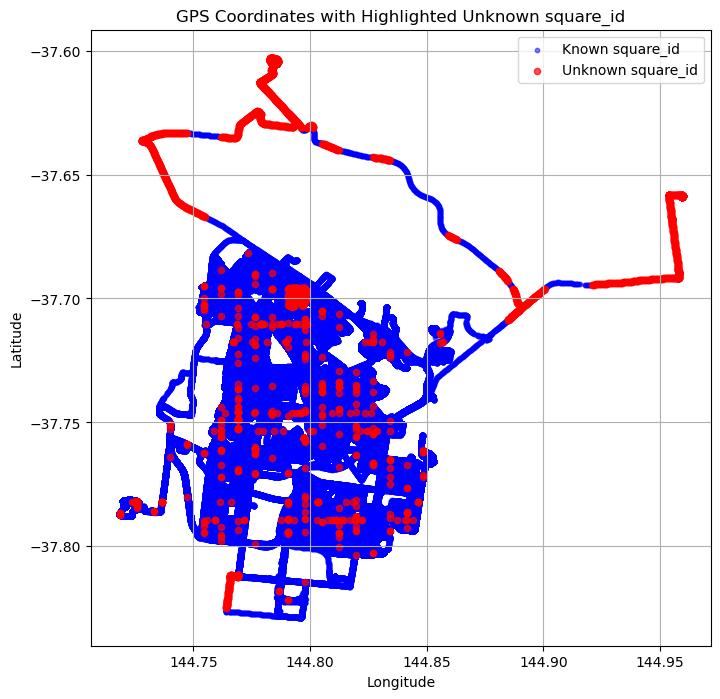

In [2]:
import matplotlib.pyplot as plt

# Separate known vs unknown square_id
df_known = df[df['square_id'] != "Unknown"]
df_unknown = df[df['square_id'] == "Unknown"]

plt.figure(figsize=(8,8))

# Plot known points
plt.scatter(df_known['longitude'], df_known['latitude'], 
            c='blue', s=10, alpha=0.5, label="Known square_id")

# Plot unknown points highlighted
plt.scatter(df_unknown['longitude'], df_unknown['latitude'], 
            c='red', s=20, alpha=0.7, label="Unknown square_id")

plt.title("GPS Coordinates with Highlighted Unknown square_id")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

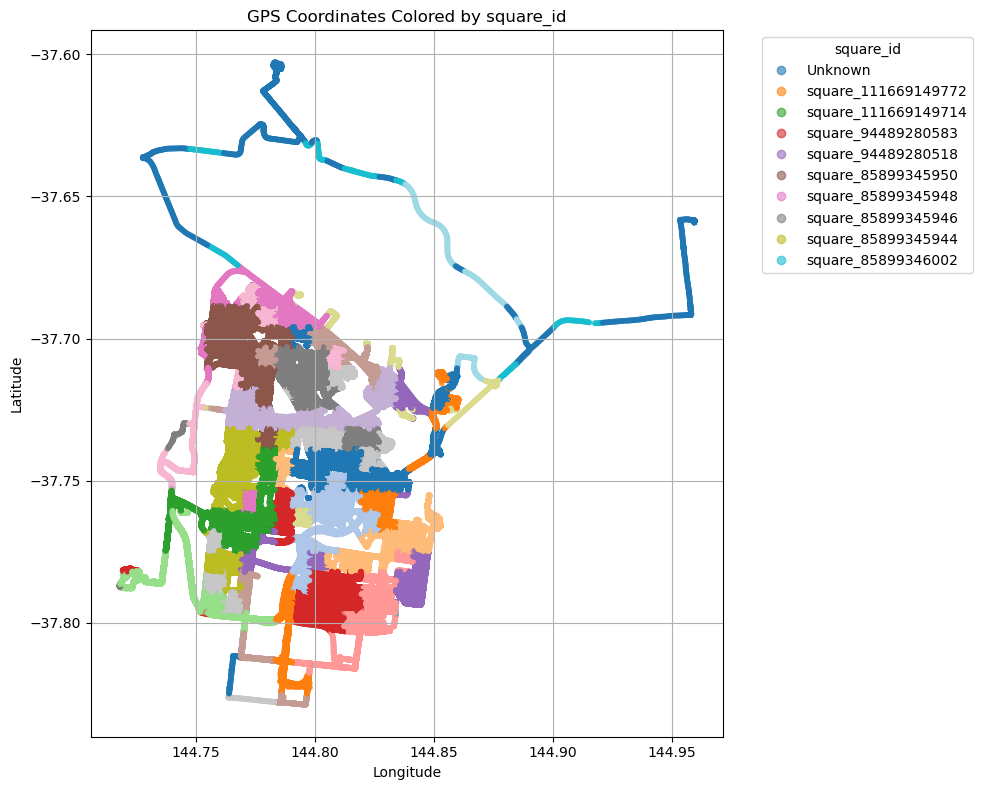

In [3]:
import matplotlib.pyplot as plt

def plot_square_id_color_coded(df):
	# Create a color-coded plot for each square_id
	plt.figure(figsize=(10, 8))

	# Scatter plot with color assigned by square_id (categorical colormap)
	scatter = plt.scatter(df['longitude'], df['latitude'], 
						c=pd.factorize(df['square_id'])[0], 
						cmap='tab20', s=10, alpha=0.6)

	# Create legend with unique square_id labels
	handles, _ = scatter.legend_elements(prop="colors", alpha=0.6)
	unique_labels = pd.unique(df['square_id'])
	plt.legend(handles, unique_labels, title="square_id", bbox_to_anchor=(1.05, 1), loc='upper left')

	plt.title("GPS Coordinates Colored by square_id")
	plt.xlabel("Longitude")
	plt.ylabel("Latitude")
	plt.grid(True)
	plt.tight_layout()
	plt.show()

plot_square_id_color_coded(df)

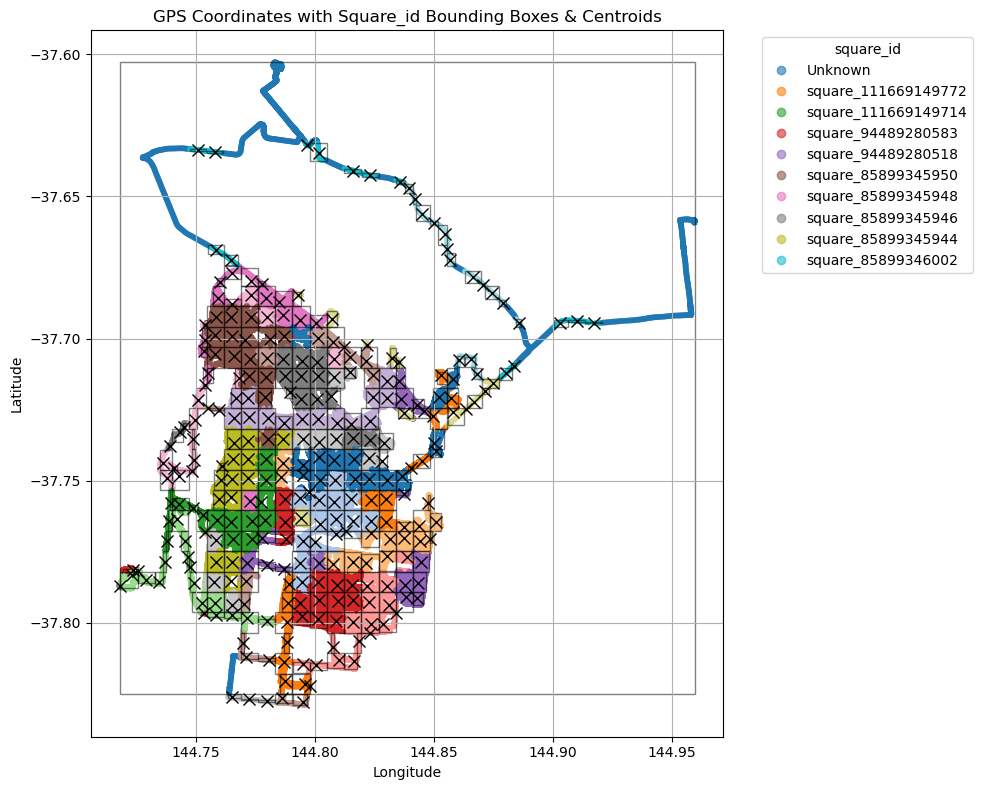

In [4]:
import matplotlib.patches as patches

# Group by square_id and compute stats
square_stats = df.groupby('square_id').agg(
    count=('square_id', 'size'),
    lat_min=('latitude', 'min'),
    lat_max=('latitude', 'max'),
    lon_min=('longitude', 'min'),
    lon_max=('longitude', 'max'),
    lat_mean=('latitude', 'mean'),
    lon_mean=('longitude', 'mean')
).reset_index()

plt.figure(figsize=(10, 8))

# Scatter all points colored by square_id
scatter = plt.scatter(df['longitude'], df['latitude'],
                      c=pd.factorize(df['square_id'])[0],
                      cmap='tab20', s=10, alpha=0.5)

# Add bounding boxes and centroids for each square_id
for _, row in square_stats.iterrows():
    # Bounding box
    rect = patches.Rectangle((row['lon_min'], row['lat_min']),
                             row['lon_max'] - row['lon_min'],
                             row['lat_max'] - row['lat_min'],
                             linewidth=1, edgecolor='black', facecolor='none', alpha=0.5)
    plt.gca().add_patch(rect)
    # Centroid
    plt.plot(row['lon_mean'], row['lat_mean'], 'kx', markersize=8)

# Legend
handles, _ = scatter.legend_elements(prop="colors", alpha=0.6)
unique_labels = pd.unique(df['square_id'])
plt.legend(handles, unique_labels, title="square_id", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("GPS Coordinates with Square_id Bounding Boxes & Centroids")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

The above graph suggests that we can further impute the "Unknown" square ids with KNNs.

C:\Users\minhd\AppData\Local\Temp\ipykernel_14956\2215450037.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unknown['square_id_bbox'] = df_unknown.apply(assign_by_bbox, axis=1)


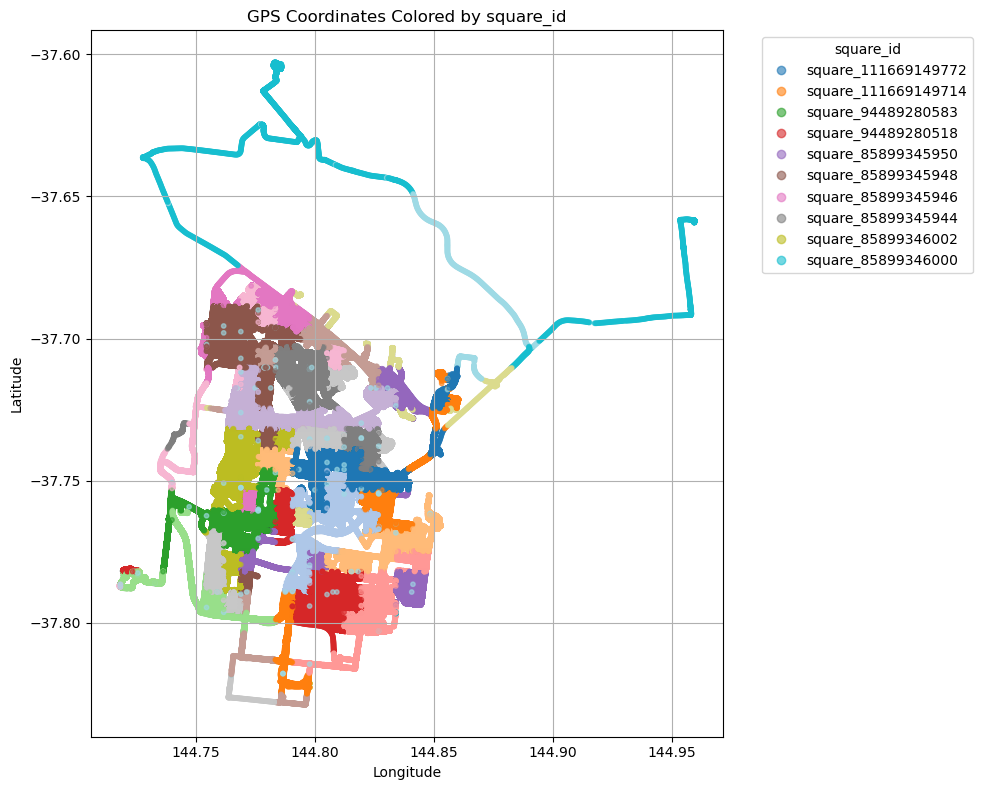

In [5]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

def assign_by_bbox(row):
    hits = square_stats[
        (square_stats.lat_min <= row.latitude) & (row.latitude <= square_stats.lat_max) &
        (square_stats.lon_min <= row.longitude) & (row.longitude <= square_stats.lon_max)
    ]
    if not hits.empty:
        # Choose the tightest box (smallest area)
        areas = (hits.lat_max - hits.lat_min) * (hits.lon_max - hits.lon_min)
        return hits.iloc[areas.values.argmin()].square_id
    return None

df_unknown['square_id_bbox'] = df_unknown.apply(assign_by_bbox, axis=1)
mask_bbox = df_unknown['square_id_bbox'].notna()
df_unknown.loc[mask_bbox, 'square_id'] = df_unknown.loc[mask_bbox, 'square_id_bbox']
df_unknown = df_unknown.drop(columns=['square_id_bbox'])

# KNN fallback on remaining Unknowns using haversine distance
remain = df_unknown[df_unknown['square_id'] == "Unknown"].copy()
if not remain.empty:
    # For now, we use lat/lon, but can add 'svr1'..'svr4' later if helpful
    X_train_ll = np.radians(df_known[['latitude','longitude']].values)
    y_train = df_known['square_id'].values
    X_remain_ll = np.radians(remain[['latitude','longitude']].values)

    knn = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='haversine')
    knn.fit(X_train_ll, y_train)
    pred = knn.predict(X_remain_ll)
    proba = knn.predict_proba(X_remain_ll).max(axis=1)

    # Confidence gating (adjust 0.6–0.8 as needed)
    conf_thresh = 0.6
    high_conf = proba >= conf_thresh
    remain.loc[high_conf, 'square_id'] = pred[high_conf]

    # Put back
    df_unknown.update(remain)

# Recombine
df_imputed = pd.concat([df_known, df_unknown], ignore_index=True)

plot_square_id_color_coded(df_imputed)

# TEMPORAL ANALYSIS

In [12]:
# Convert UNIX time to datetime for temporal analysis
df['datetime'] = pd.to_datetime(df['time'], unit='s')

# Extract useful temporal features
df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.day_name()

# Time coverage
time_min = df['datetime'].min()
time_max = df['datetime'].max()

# Count of records by day
records_per_day = df['date'].value_counts().sort_index()

# Count of records by hour (across dataset)
records_per_hour = df['hour'].value_counts().sort_index()

# Distribution by day of week
records_per_dow = df['dayofweek'].value_counts()

time_min, time_max, records_per_day, records_per_hour, records_per_dow

(Timestamp('1901-12-13 20:45:52'),
 Timestamp('2022-07-22 08:30:00'),
 date
 1901-12-13         2
 2022-07-03    124439
 2022-07-04    251418
 2022-07-05    215885
 2022-07-06    234318
 2022-07-07    165023
 2022-07-08     61753
 2022-07-10    109059
 2022-07-11    176375
 2022-07-12    158194
 2022-07-13    158658
 2022-07-14    179776
 2022-07-15     74267
 2022-07-17     95441
 2022-07-18    159681
 2022-07-19    143482
 2022-07-20    175639
 2022-07-21    162877
 2022-07-22     81963
 Name: count, dtype: int64,
 hour
 0     361491
 1     307026
 2     261030
 3     122496
 4      43030
 5      32757
 6      24678
 7      12043
 8       5401
 9        162
 18      2110
 19    134453
 20    347331
 21    357560
 22    355076
 23    361606
 Name: count, dtype: int64,
 dayofweek
 Monday       587474
 Wednesday    568615
 Tuesday      517561
 Thursday     507676
 Sunday       328939
 Friday       217985
 Name: count, dtype: int64)

Date contains an outlier (1901-12-13)

In [13]:
# Calculate time differences between consecutive records
df = df.sort_values('datetime').reset_index(drop=True)
df['time_diff_sec'] = df['datetime'].diff().dt.total_seconds()

# Summary statistics for sampling interval
time_diff_summary = df['time_diff_sec'].describe()

# Most common intervals (to detect logging frequency)
time_diff_counts = df['time_diff_sec'].value_counts().head(10)

# Percentage of missing (NaN) in first row due to diff
nan_in_diff = df['time_diff_sec'].isna().sum()

time_diff_summary, time_diff_counts, nan_in_diff

(count    2.728249e+06
 mean     1.395020e+03
 std      2.303241e+06
 min      0.000000e+00
 25%      0.000000e+00
 50%      0.000000e+00
 75%      0.000000e+00
 max      3.804358e+09
 Name: time_diff_sec, dtype: float64,
 time_diff_sec
 0.0    2146135
 1.0     581745
 2.0        220
 6.0         18
 5.0         13
 3.0         11
 4.0          8
 7.0          4
 9.0          3
 8.0          3
 Name: count, dtype: int64,
 1)